In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -d

Sebastian Raschka 20/12/2014 

CPython 3.4.2
IPython 2.3.1


<br>
<br>

# Turn Your Twitter Timeline into a Word Cloud Using Python

<br>
<br>

### Sections

- [Requirements](#Requirements)
- [A. Downloading Your Twitter Timeline Tweets](#A.-Downloading-Your-Twitter-Timeline-Tweets)
- [B. Creating the Word Cloud](#A.-Downloading-Your-Twitter-Timeline-Tweets)

<br>
<br>

### Requirements

[[back to top](#Sections)]

Before we get started, I want to list some of the required packages to make this work!

Below, you find a list of the basic packages which can be installed via

    pip install <package_name>

- [twitter](https://pypi.python.org/pypi/twitter)
- [pyprind](https://pypi.python.org/pypi/PyPrind/)
- [numpy](http://numpy.org)
- [matplotlib](http://matplotlib.org)
- [pandas](http://pandas.pydata.org)
- [scipy](http://www.scipy.org)




And the Python (2.7) [`wordcloud`](https://github.com/amueller/word_cloud) package by Andreas Mueller can be installed via

    pip install git+git://github.com/amueller/word_cloud.git
    
Note that `wordcloud` requires Python's imaging library [PIL](http://effbot.org/imagingbook/pil-index.htm). Depending on the operating system, the installation and setup of PIL can be quite challenging; however, when I tried to install it on different MacOS and Linux systems via [`conda`](http://www.continuum.io/blog/conda) it always seemed to work seamlessly:

    conda install pil

Let me use my handy [`watermark`](https://github.com/rasbt/watermark) extension to summarize the different packages and version numbers that were used in my case to download the twitter timeline and create the word cloud:

In [1]:
%load_ext watermark
%watermark -d -v -m -p twitter,pyprind,wordcloud,pandas,scipy,matplotlib

28/11/2014 

CPython 2.7.8
IPython 2.1.0

twitter 1.15.0
pyprind 2.8.0
wordcloud 1.0.0
pandas 0.14.1
scipy 0.14.0
matplotlib 1.3.1

compiler   : GCC 4.2.1 (Apple Inc. build 5577)
system     : Darwin
release    : 14.0.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit


<br>
<br>

## A. Downloading Your Twitter Timeline Tweets

[[back to top](#Sections)]

In order to get access to the Twitter API through OAuth (open standard for authorization), we have to obtain our consumer information and access tokens first by registering our app on [https://apps.twitter.com](https://apps.twitter.com).

In [ ]:
CONSUMER_KEY = 'enter your information here'
CONSUMER_SECRET = 'enter your information here'
ACCESS_TOKEN = 'enter your information here'
ACCESS_TOKEN_SECRET = 'enter your information here'
USER_NAME = 'enter your twitter handle here'

The following code can then be used to download your timeline "sequentially" in chunks of 200 tweets per request to overcome the twitter API limitation, which only allows you to download 200 tweets at a time.

In [ ]:
# Sebastian Raschka, 2014
# Code for downloading your personal twitter timeline.

import twitter
from datetime import datetime
import time
import re
import sys
import pandas as pd
import pyprind as pp

class TimelineMiner(object):
    def __init__(self, access_token, access_secret, consumer_key, consumer_secret, user_name):
        self.access_token = access_token
        self.access_secret = access_secret
        self.consumer_key = consumer_key
        self.consumer_secret = consumer_secret
        self.user_name = user_name
        self.auth = None
        self.df = pd.DataFrame(columns=['timestamp', 'tweet'], dtype='str')


    def authenticate(self):
        self.auth = twitter.Twitter(auth=twitter.OAuth(self.access_token, 
                    self.access_secret, self.consumer_key, 
                    self.consumer_secret))
        return bool(isinstance(self.auth, twitter.api.Twitter))
        

    def get_timeline(self, max=0, keywords=[]):
        if keywords:
            self.df['keywords'] = ''
        tweet_ids = [self.auth.statuses.user_timeline(
                user_id=self.user_name, count=1
                )[0]['id']] # the ID of my last tweet
        last_count = 200
        counter = 0
        while last_count == 200:
            timeline = self.auth.statuses.user_timeline(user_id=self.user_name, count=200, max_id=tweet_ids[-1])
            for tweet in range(len(timeline)):
        
                text = timeline[tweet]['text'].replace('"', '\'')
                tweet_id = int(timeline[tweet]['id'])
                date = self.__get_date(timeline, tweet)
                
                if keywords:
                    for k in keywords:
                        if self.__check_keyword(text,k):
                            self.df.loc[counter,'tweet'] = text
                            self.df.loc[counter,'timestamp'] = date
                            try:
                                self.df.loc[counter,'keywords'].append(k)
                            except AttributeError:
                                self.df.loc[counter,'keywords'] = [k]
                    try:
                        self.df.loc[counter,'keywords'] = ';'.join(self.df.loc[counter,'keywords'])
                    except KeyError:
                        pass
                        
                    
                else:
                    self.df.loc[counter,'tweet'] = text
                    self.df.loc[counter,'timestamp'] = date
                              
                counter += 1
                if max and counter >= max:
                    break
                
                sys.stdout.flush()   
                sys.stdout.write('\rTweets downloaded: %s' %counter)   
                    
            if max and counter >= max:
                break
            last_count = len(timeline)
            tweet_ids.append(timeline[-1]['id'])
            time.sleep(1)
        print()
        
    def make_csv(self, path):
        self.df.to_csv(path, encoding='utf8')

    def __get_date(self, timeline, tweet):
        timest = datetime.strptime(timeline[tweet]['created_at'],
                                      "%a %b %d %H:%M:%S +0000 %Y")
        date = timest.strftime("%Y-%d-%m %H:%M:%S")
        return date
    
    def __check_keyword(self, s, key):
        return bool(re.search(key, s, re.IGNORECASE))

In [2]:
tm = twitter_timeline.TimelineMiner(ACCESS_TOKEN, 
                                    ACCESS_TOKEN_SECRET,  
                                    CONSUMER_KEY, 
                                    CONSUMER_SECRET,
                                    USER_NAME)

print('Authentification successful: %s' %tm.authenticate())
tm.get_timeline(max=2000, keywords=[])

Authentification successful: True
Tweets downloaded: 1999()


In [3]:
tm.df.head()

timestamp                                              tweet
0  2014-28-11 22:28:52  RT @freakonometrics: 'Personality, Gender, and...
1  2014-28-11 22:18:33  A short overview about 'How to quickly turn an...
2  2014-28-11 18:13:14  RT @vmirly: A great resource for Bayesian Meth...
3  2014-27-11 06:00:01  @sirishasun thanks! There is a light at the en...
4  2014-27-11 03:52:58  @AnthonyNystrom I don't know exactly what it i...

If the `twitter_timeline.py` script was executed terminal, you can read the "tweets" from the CSV file via

    import pandas as pd
    df = pd.read_csv('path/to/CSV')

<br>
<br>

## B. Creating the Word Cloud

[[back to top](#Sections)]

Now that we collected the tweets from our twitter timeline the creation of the word cloud is pretty simple and straightforward thanks to the nice `wordcloud` module.

In [4]:
%matplotlib inline

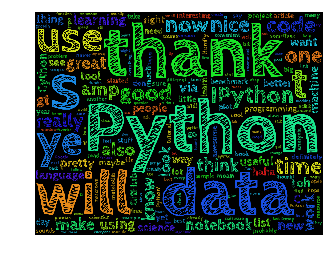

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# join tweets to a single string
words = ' '.join(tm.df['tweet'])

# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split() 
                            if 'http' not in word 
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud( 
                      font_path='/Users/sebastian/Library/Fonts/CabinSketch-Bold.ttf',
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400
                     ).generate(no_urls_no_tags)

plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('./my_twitter_wordcloud_1.png', dpi=300)
plt.show()

Surprise, surprise: The most common term I used in my tweets is obviously "Python!"

<br>
<br>

To make the word cloud even more visually appealing, let us as a custom shape in form of the twitter logo:

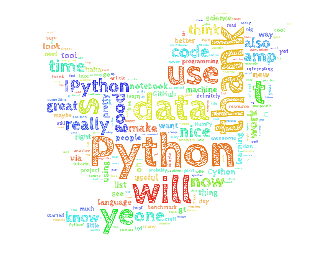

In [16]:
from scipy.misc import imread

twitter_mask = imread('./twitter_mask.png', flatten=True)


wordcloud = WordCloud( 
                      font_path='/Users/sebastian/Library/Fonts/CabinSketch-Bold.ttf',
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=1800,
                      height=1400,
                      mask=twitter_mask
            ).generate(no_urls_no_tags)

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./my_twitter_wordcloud_2.png', dpi=300)
plt.show()

(You can find the `twitter_mask.png` [here](https://raw.githubusercontent.com/rasbt/datacollect/master/dataviz/twitter_cloud/twitter_mask.png))